
This Jupyter Notebook contains the implementation of my initial model. If you wish to directly test my model by providing inputs, you can navigate to the final cells of this notebook. Below are the instructions on how to provide inputs:

1. Click on the following SavedSVMResources  to download the saved model file named 'svm_model.pkl'.
2. Additionally, download 'BioRed-vectors.kv' and 'tfidf_vectorizer.joblib' from the same link.
3. Ensure that all necessary libraries are downloaded by executing the first cell.
4. Also make sure to place the downloaded files in the same Path where the model is being executed.
5. Execute the last cell, following which you can input custom biomedical data in the specified format.
6. A sample custom input has already been provided to the model to obtain the prediction class.

#### Installing all necessary libraries

In [ ]:
!pip3 install gensim numpy pandas spacy scikit-learn joblib seaborn matplotlib nltk
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importing necessary libraries
import json
import os

### Data Collection:
We downloaded the Biored dataset zip file from https://ftp.ncbi.nlm.nih.gov/pub/lu/BioRED/, which was in JSON format, and commenced with data preprocessing using Python.


##Relevant files and resources for executing this model
Link : https://drive.google.com/drive/folders/1xA57_2PfXqoHG8teUAlSSMMpDVbZKkIJ?usp=drive_link

### Document Conversion to Simplified JSON Format

The following function, `convert_documents`, is designed to transform the json documents into a specifically structured JSON format. The conversion process is crucial for preparing the data for downstream tasks such as relation extraction or entity recognition. This function takes 'documents', which is expected to be a dictionary that contains a list of document data under the key "documents".

Each document is processed to extract 'relations' and 'passages'. The aim is to construct a JSON object for each passage that captures:

- The full sentence that the passage text represents.
- Entities involved in the relations.
- Types of these entities.
- Start and end positions of these entities within the sentence.
- The relation type between the entities.
- The sequence of words between entities and the number of words in this sequence.
- A calculated 'proximity distance' between entities, which could be essential for certain types of analysis.

This structured format is instrumental for subsequent machine learning tasks, where specific information about entity relations is necessary for training and model evaluation. After processing all documents, the function returns a list of these JSON objects, ready for further processing.


In [ ]:
# Run this cell only if you are using Google Colab.
#If you want to run it in local please download the model from the zip file or google drive link provided and change path accordingly.
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/BioRed_TextMining_SVM
!ls

Mounted at /gdrive
/gdrive/MyDrive/BioRed_TextMining_SVM
BioRed-vectors.kv  Test.BioC.JSON  tfidf_vectorizer.joblib  train.JSON
svm_model.pkl	   test.JSON	   Train.BioC.JSON


In [ ]:
def convert_documents(documents):
    JSON = []
    for doc in documents["documents"]:
        for relation in doc["relations"]:
            for passage in doc["passages"]:
                obj = {}
                obj["sentence"] = ""
                annotation1 = next(
                    (annotation for annotation in passage['annotations'] if annotation['infons']['identifier'] == relation["infons"]["entity1"]), None)
                annotation2 = next(
                    (annotation for annotation in passage['annotations'] if annotation['infons']['identifier'] == relation["infons"]["entity2"]), None)
                if annotation1 and annotation2:
                    obj["sentence"] += str(passage['text'] + ' ')

            if annotation1 and annotation2:
                # Extract information for the first entity.
                obj["e1"] = annotation1["text"]
                obj["entity1_type"] = annotation1["infons"]["type"]
                obj["e1strt"] = obj["sentence"].find(annotation1["text"])
                obj["e1end"] = obj["e1strt"] + len(obj["e1"]) - 1
                # Extract information for the second entity.
                obj["e2"] = annotation2['text']
                obj["entity2_type"] = annotation2["infons"]["type"]
                obj["e2strt"] = obj["sentence"].find(annotation2["text"])
                obj["e2end"] = obj["e2strt"] + len(obj["e2"]) - 1
                # Extract the relationship information.
                obj["relation"] = relation["infons"]["type"]
                 # Extract the sequence of words between the two entities.
                obj["word_sequence"] = obj["sentence"][obj["e1end"]:obj["e2strt"]].strip()
                # Calculate the number of words between the two entities.
                obj["no_of_words_between_entites"] = len(obj["word_sequence"].split())
                # Calculate the proximity distance between the two entities.
                obj["proximty_distance"] = len(obj["word_sequence"])
                JSON.append(obj)
    return JSON

In [ ]:
# Open the source JSON file for reading.
with open('Test.BioC.JSON', 'r') as file:
    data = json.load(file)
output_data = convert_documents(data)

In [ ]:
# Open a new JSON file for writing the output data.
with open('test.JSON', 'w') as output_file:
    json.dump(output_data, output_file, indent=4)

#### Importing Libraries and Packages

In [ ]:
import json
import pandas as pd
import nltk
import spacy

# Sklearn modules for machine learning tasks.
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# NLTK downloads for specific tokenizer and tagger
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import numpy as np

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#### Data Loading and Text Preprocessing Functions

In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

In [ ]:
# Load the small English model for spaCy
spacy_nlp = spacy.load("en_core_web_sm")

In [ ]:
def tokenize_text(text):
    sentence = spacy_nlp(text)
    # Tokenize the text into individual words using NLTK.
    return nltk.word_tokenize(text)

In [ ]:
# Load the Dataset
bio_red_data = load_data('train.JSON')
bio_red_test_data = load_data('test.JSON')

In [ ]:
# Preview the Training Data
bio_red_data.head()

,sentence,e1,entity1_type,e1strt,e1end,e2,entity2_type,e2strt,e2end,relation,word_sequence,no_of_words_between_entites,proximty_distance
0,The transcription factor hepatocyte nuclear fa...,hepatocyte nuclear factor (HNF)-6,GeneOrGeneProduct,25,57,maturity-onset diabetes,DiseaseOrPhenotypicFeature,133,155,Association,6 is an upstream regulator of several genes in...,13,75
1,The transcription factor hepatocyte nuclear fa...,glucose,ChemicalEntity,359,365,insulin,GeneOrGeneProduct,284,290,Positive_Correlation,,0,0
2,The transcription factor hepatocyte nuclear fa...,glucose,ChemicalEntity,359,365,maturity-onset diabetes,DiseaseOrPhenotypicFeature,133,155,Association,,0,0
3,We have identified a type II Ca2+-dependent le...,type II Ca2+-dependent lectin,GeneOrGeneProduct,21,49,mannose,ChemicalEntity,62,68,Bind,n displaying,2,12
4,"We have undertaken a hospital-based study, to ...",breast cancers,DiseaseOrPhenotypicFeature,476,489,5382insC,SequenceVariant,1387,1394,Positive_Correlation,s only. Genomic DNA was prepared from the peri...,149,897


#### Text Tokenization and Word2Vec Model Training

In [ ]:
# Tokenize the sentences in the training and test data
bio_red_data['Tokenized_Sentence'] = bio_red_data['sentence'].apply(tokenize_text)
bio_red_test_data['Tokenized_Sentence'] = bio_red_test_data['sentence'].apply(tokenize_text)

# Initialize Word2Vec model with specified parameters and train it
model = Word2Vec(bio_red_data['Tokenized_Sentence'], vector_size=300, window = 15, min_count = 1, workers = 15)
model.train(bio_red_data['Tokenized_Sentence'], total_examples=len(bio_red_data['Tokenized_Sentence']), epochs = 30)

(23397643, 31211940)

In [ ]:
# Save the word vectors to a KeyedVectors format
wv = model.wv
wv.save('BioRed-vectors.kv')

#### Sentence Vectorization and Entity POS Tag finder functions

In [ ]:
# Sentence Vectorization Function
def sentence_vec(words):
  '''
  function that takes a word or a sequence of words as input and outputs the sentence's vector representation
  by taking average of all word vectors present in the sentence
  '''
  sent_vec = np.zeros(300)
  num_words = 0
  for word in words:
    if word in wv:
      sent_vec += wv[word]
      num_words += 1
  sent_vec = sent_vec / num_words
  return sent_vec

# Entity POS Tag Finder Function
def find_e1_e2_pos_tag(row):
  sentence = row['sentence']
  # e1 and e2 can contain more than one word. So for both e1 and e2 we get the first word and find its POS tag.
  e1 = row['e1'].split()[0]
  e2 = row['e2'].split()[0]
  doc = spacy_nlp(sentence)
  e1_pos, e2_pos = 8, 8
  for token in doc:
    if token.text == e1:
      e1_pos = token.pos
    elif token.text == e2:
      e2_pos = token.pos
  return e1_pos, e2_pos

In [ ]:
df = pd.DataFrame(bio_red_data,columns = ['sentence', 'e1', 'e2', 'entity1_type', 'entity2_type', 'word_sequence','no_of_words_between_entites', 'proximty_distance','relation'])
df_test = pd.DataFrame(bio_red_test_data,columns = ['sentence', 'e1', 'e2', 'entity1_type', 'entity2_type', 'word_sequence','no_of_words_between_entites', 'proximty_distance','relation'])

#### Visualize the Data

This bar chart illustrates the distribution of different types of relationships found within the dataset. Each bar represents the frequency of a particular relationship category, such as 'Association', 'Positive_Correlation', 'Negative_Correlation', among others.

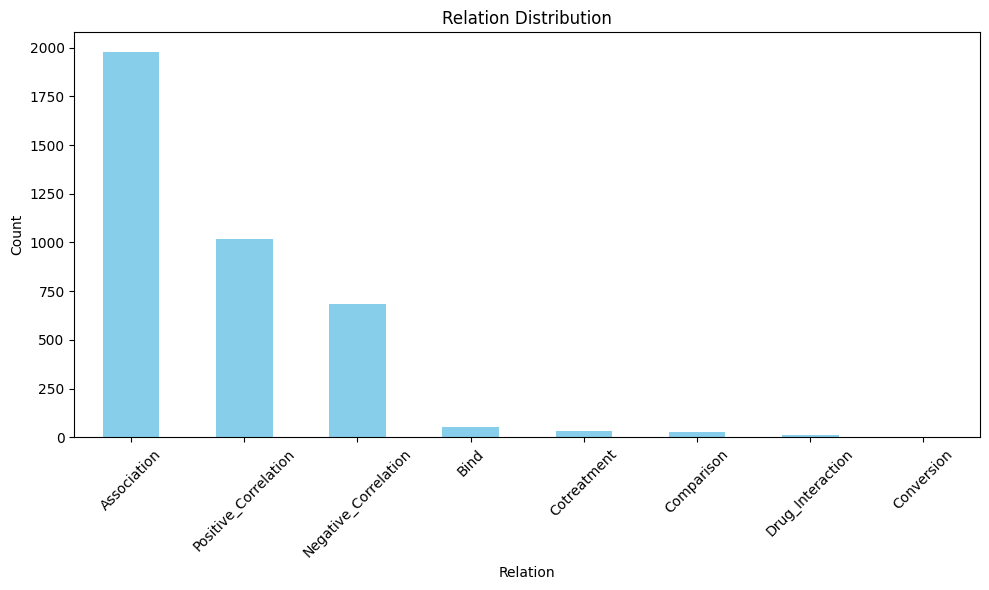

In [ ]:
plt.figure(figsize=(10, 6))
df['relation'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Relation Distribution')
plt.xlabel('Relation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the chart, we can observe that 'Association' is the most common type of relationship, followed by 'Positive_Correlation' and 'Negative_Correlation'. Categories like 'Bind', 'Cotreatment', 'Comparison', 'Drug_Interaction', and 'Conversion' are less frequent in comparison. This visualization helps in understanding the imbalance in the dataset which might be an important factor to consider during the model training process.

#### Feature Engineering for Train and Test Data

In [ ]:
# Train Data Vectorization
df['sentence_vector'] = bio_red_data['Tokenized_Sentence'].apply(sentence_vec)
df['e1_vec'] = df['e1'].apply(sentence_vec)
df['e2_vec'] = df['e2'].apply(sentence_vec)
df['e1_e2_pos_tags'] = df.apply(find_e1_e2_pos_tag, axis=1)

In [ ]:
# Test Data Vectorization
df_test['sentence_vector'] = bio_red_test_data['Tokenized_Sentence'].apply(sentence_vec)
df_test['e1_vec'] = df_test['e1'].apply(sentence_vec)
df_test['e2_vec'] = df_test['e2'].apply(sentence_vec)
df_test['e1_e2_pos_tags'] = df_test.apply(find_e1_e2_pos_tag, axis=1)

#### TF-IDF Vectorization

In [ ]:
# Initialize and fit TF-IDF vectorizer to the sentences in the training data
vectorizer = TfidfVectorizer(max_features=200)
vectorizer.fit(df['sentence'])

TfidfVectorizer(max_features=200)

In [ ]:
# Transform sentences into TF-IDF feature vectors for both training and test datasets
tfidf_features = vectorizer.transform(df['sentence'].to_list()).toarray()
tfidf_features_test = vectorizer.transform(df_test['sentence'].to_list()).toarray()

#### One Hot Encoding of Categorical Variables

In [ ]:
# One Hot Encoding for categorical features
encoded_cats = pd.get_dummies(df[['entity1_type', 'entity2_type']])
encoded_cats_test = pd.get_dummies(df_test[['entity1_type', 'entity2_type']])

#### Label Encoding of Target Variable

In [ ]:
# Initialize label encoder and transform the 'relation' column into numerical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df['relation'])
y_test = label_encoder.fit_transform(df_test['relation'])

In [ ]:
# Create a mapping of class names to numerical labels
classes = label_encoder.classes_
label_mapping = {label: index for index, label in enumerate(classes)}
print(label_mapping)

{'Association': 0, 'Bind': 1, 'Comparison': 2, 'Conversion': 3, 'Cotreatment': 4, 'Drug_Interaction': 5, 'Negative_Correlation': 6, 'Positive_Correlation': 7}


#### Assembling Feature Vectors


In [ ]:
# Assemble feature vectors for the training set
X_train = [
    np.concatenate((
        row['sentence_vector'],
        row['e1_vec'],
        row['e2_vec'],
        row["e1_e2_pos_tags"],
        tfidf_features[idx],  # Assuming tfidf_features is a DataFrame
        encoded_cats.iloc[idx].values,  # Include the one-hot encoded categorical features
    )) for idx, row in df.iterrows()
]

In [ ]:
# Repeat the process for the test set
X_test = [
    np.concatenate((
        row['sentence_vector'],
        row['e1_vec'],
        row['e2_vec'],
        row["e1_e2_pos_tags"],
        tfidf_features_test[idx],  # Assuming tfidf_features is a DataFrame
        encoded_cats_test.iloc[idx].values,  # Include the one-hot encoded categorical features
    )) for idx, row in df_test.iterrows()
]


#### Hyperparameter Tuning on a SVM Classifier : GRID SEARCH

In [ ]:
# Hyperparameter tuning for SVM classifier
C_values = [50, 100, 150, 200]
gamma_values = [0.1, 0.01, 0.001, 0.0001]

# Iterate over all combinations of C and gamma values
for C in C_values:
  for gamma in gamma_values:
    # Initialize SVM with current C and gamma values
    svm_model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')  # Micro F1 score for multiclass classification
    precision = precision_score(y_test, y_pred, average='micro')  # Micro precision for multiclass classification
    recall = recall_score(y_test, y_pred, average='micro')  # Micro recall for multiclass classification

    # Print the evaluation metrics
    print("Model with C=", C, " gamma=", gamma)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)

Model with C= 50  gamma= 0.1
Accuracy: 0.5199579831932774
F1 Score: 0.5199579831932774
Precision: 0.5199579831932774
Recall: 0.5199579831932774
Model with C= 50  gamma= 0.01
Accuracy: 0.5441176470588235
F1 Score: 0.5441176470588235
Precision: 0.5441176470588235
Recall: 0.5441176470588235
Model with C= 50  gamma= 0.001
Accuracy: 0.4894957983193277
F1 Score: 0.4894957983193277
Precision: 0.4894957983193277
Recall: 0.4894957983193277
Model with C= 50  gamma= 0.0001
Accuracy: 0.5504201680672269
F1 Score: 0.5504201680672269
Precision: 0.5504201680672269
Recall: 0.5504201680672269
Model with C= 100  gamma= 0.1
Accuracy: 0.5199579831932774
F1 Score: 0.5199579831932774
Precision: 0.5199579831932774
Recall: 0.5199579831932774
Model with C= 100  gamma= 0.01
Accuracy: 0.5441176470588235
F1 Score: 0.5441176470588235
Precision: 0.5441176470588235
Recall: 0.5441176470588235
Model with C= 100  gamma= 0.001
Accuracy: 0.4737394957983193
F1 Score: 0.4737394957983193
Precision: 0.4737394957983193
Recall:

Optimal Parameters for the Model are C= 50  gamma= 0.0001


In [ ]:
svm_model = svm.SVC(kernel='rbf', C=50, gamma=0.0001)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       495
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00         2
           6       0.34      0.22      0.27       159
           7       0.41      0.37      0.39       270

    accuracy                           0.55       952
   macro avg       0.17      0.17      0.17       952
weighted avg       0.51      0.55      0.52       952



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report shows the performance of the SVM classifier on the test set. Each row corresponds to a class in our dataset, and the columns provide metrics such as precision, recall, and F1-score for each class.

The macro-average gives us an unweighted average performance across classes, while the weighted average takes the support into account, providing a performance metric that is weighted by the number of true instances for each label.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5504201680672269
F1 Score: 0.5504201680672269
Precision: 0.5504201680672269
Recall: 0.5504201680672269


In [ ]:
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[388   0   0   0   0   0  26  81]
 [  5   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   3   2]
 [  0   0   0   0   0   0   0   1]
 [  2   0   0   0   0   0   9   3]
 [  0   0   0   0   0   0   0   2]
 [ 65   0   0   0   0   0  35  59]
 [139   1   0   0   0   0  29 101]]


The confusion matrix provides a tabular representation of the actual versus predicted classes.

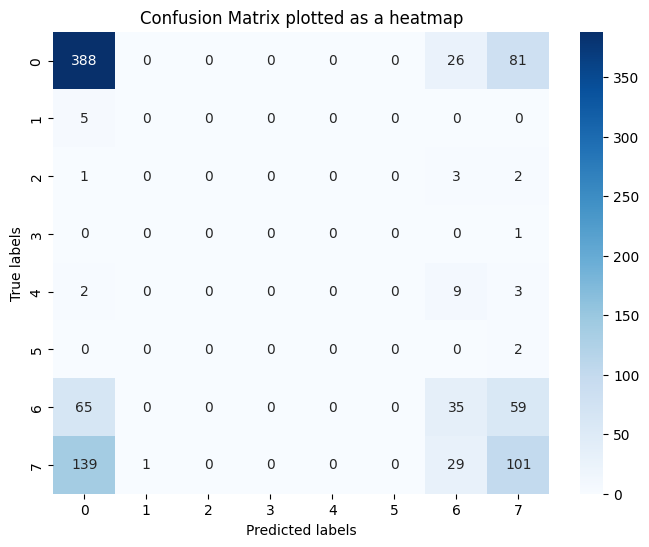

In [ ]:
# Plot heatmap
labels = [i for i in range(8)]
plt.figure(figsize=(8, 6))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix plotted as a heatmap')
plt.show()

The heatmap above provides a visual interpretation of the confusion matrix, offering a color-coded representation of how well the model is classifying the different classes. In this matrix, the x-axis represents the predicted labels, while the y-axis represents the true labels. The color intensity and the number in each cell correspond to the count of instances, making it easy to identify which classes are being confused with each other.

#### Saving Model

In [ ]:
# Save model and tf-idf vectorizer
from joblib import dump

dump(svm_model, 'svm_model.pkl')
dump(vectorizer, 'tfidf_vectorizer.joblib')

print("Saved SVM model and TF-IDF vectorizer!")

Saved SVM model and TF-IDF vectorizer!


#### The following blocks of code can be used to test our model based on user input

In [ ]:
# Run this cell only if you are using Google Colab.
#If you want to run it in local please download the model from the zip file or google drive link provided and change path accordingly.
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/BioRed_TextMining_SVM
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/BioRed_TextMining_SVM
BioRed-vectors.kv  Test.BioC.JSON  tfidf_vectorizer.joblib  train.JSON
svm_model.pkl	   test.JSON	   Train.BioC.JSON


**Preparing the NLP Environment for Predictions**

Run the code block below to set up the environment necessary for processing and predicting entity relationships.

In [ ]:
from joblib import load
import re
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer
from gensim.models import KeyedVectors

nlp = spacy.load('en_core_web_sm')

# load saved word embeddings
wv = KeyedVectors.load('BioRed-vectors.kv')

# load saved svm model and tf-idf vectorizer
loaded_model = load('svm_model.pkl')
loaded_tfidf_vectorizer = load("tfidf_vectorizer.joblib")

def tokenize_text(text):
    return nltk.word_tokenize(text)

def sentence_vec(words):
  '''
  function that takes a word or a sequence of words as input and outputs the sentence's vector representation
  by taking average of all word vectors present in the sentence
  '''
  sent_vec = np.zeros(300)
  num_words = 0
  for word in words:
    if word in wv:
      sent_vec += wv[word]
      num_words += 1
  sent_vec = sent_vec / num_words
  return sent_vec

# function that finds e1 and e2 and returns their POS tags
def find_e1_e2_pos_tag(row):
  '''
  Function that finds out the POS tag of e1 and e2.
  Returns a tuple containing POS tag IDs of e1 and e2
  '''
  sentence = row['sentence']
  e1 = row['e1'].split()[0]
  e2 = row['e2'].split()[0]
  doc = nlp(sentence)
  e1_pos, e2_pos = 8, 8
  for token in doc:
    if token.text == e1:
      e1_pos = token.pos
    elif token.text == e2:
      e2_pos = token.pos
  return e1_pos, e2_pos

# function to make predictions
def predict_with_loaded_model(data):
  prediction_df = pd.DataFrame(data, columns=['sentence', 'e1', 'e2', 'entity1_type','entity2_type'])
  prediction_df['sentence_vector'] = prediction_df['sentence'].apply(sentence_vec)
  prediction_df['e1_vec'] = prediction_df['e1'].apply(sentence_vec)
  prediction_df['e2_vec'] = prediction_df['e2'].apply(sentence_vec)
  prediction_df['e1_e2_pos_tags'] = prediction_df.apply(find_e1_e2_pos_tag, axis=1)
  tfidf_features_for_prediction = loaded_tfidf_vectorizer.transform(prediction_df['sentence'].to_list()).toarray()
  encoded_cats = pd.get_dummies(prediction_df[['entity1_type', 'entity2_type']])

  X = [
    np.concatenate((
        row['sentence_vector'],
        row['e1_vec'],
        row['e2_vec'],
        row["e1_e2_pos_tags"],
        tfidf_features_test[idx],  # Assuming tfidf_features is a DataFrame
        encoded_cats_test.iloc[idx].values,  # Include the one-hot encoded categorical features
    )) for idx, row in prediction_df.iterrows()
  ]
  predictions = loaded_model.predict(X)
  # Each prediction is an id correspoding to the respective relation
  # Hence, we convert each id to its corresponding relation text

  id_2_relation = {
      0: 'Association',
      1: 'Bind',
      2: 'Comparison',
      3: 'Conversion',
      4: 'Cotreatment',
      5: 'Drug_Interaction',
      6: 'Negative_Correlation',
      7: 'Positive_Correlation'
  }
  predicted_relations = [id_2_relation[pred] for pred in predictions]
  print(predicted_relations)


In [ ]:
#If you want to give the custom input please follow below format to get the Output without any errors.
#replace below sentence, e1 is entity1, e2 is entity2, entity1_type and entity2_type is type of entity
inputs =[ {
        "sentence": "Deoxyguanosine kinase (dGK) deficiency is a frequent cause of mitochondrial DNA depletion associated with a hepatocerebral phenotype. In this study, we describe a new splice site mutation in the DGUOK gene and the clinical, radiologic, and genetic features of these DGUOK patients. This new DGUOK homozygous mutation (c.444-62C>A) was identified in three patients from two North-African consanguineous families with combined respiratory chain deficiencies and mitochondrial DNA depletion in the liver. Brain MRIs are normal in DGUOK patients in the literature. Interestingly, we found subtentorial abnormal myelination and moderate hyperintensity in the bilateral pallidi in our patients. This new mutation creates a cryptic splice site in intron 3 (in position -62) and is predicted to result in a larger protein with an in-frame insertion of 20 amino acids. In silico analysis of the putative impact of the insertion shows serious clashes in protein conformation: this insertion disrupts the alpha5 helix of the dGK kinase domain, rendering the protein unable to bind purine deoxyribonucleosides. In addition, a common haplotype that segregated with the disease in both families was detected by haplotype reconstruction with 10 markers (microsatellites and SNPs), which span 4.6 Mb of DNA covering the DGUOK locus. In conclusion, we report a new DGUOK splice site mutation that provide insight into a critical protein domain (dGK kinase domain) and the first founder mutation in a North-African population. ",
        "e1": "DGUOK",
        "entity1_type": "GeneOrGeneProduct",
        "e2": "Deoxyguanosine kinase (dGK) deficiency",
        "entity2_type": "DiseaseOrPhenotypicFeature",
    }]
predict_with_loaded_model(inputs)

['Association']
